# Experiment 2: Do V20 lake fields + some extra surface fields improve our predicitions?

We compare two models:

* `V15`: A model using time variable features + `'cl_v15','lsm_v15','dl_v15','cvl_v15','cvh_v15','anor_v15','isor_v15','slor_v15','sr_v15','lsrh_v15'`
* `V20`: A model using time variable features, the above `*_v15` fields + corresponding V20 corrections for all the 

The correction is obtained by calculating e.g. `cl_V20 - cl_V15`.

To see how these fields change when going from V15 to V20, check out the `A1.V20_vs_V15.ipynb` notebook in this directory.

---



# 1. Plot model performance and difference

We have a V15 model which has some error relative to the true, observed data.

Ditto a V20 model.

Lets plot the error maps for each of these models, and also plot the difference in the error maps.

In [1]:
import pandas as pd
import json
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import matplotlib.colors as mc
import matplotlib.colorbar as cb 


def load_predictions(path):

    df = pd.read_pickle(path+'predictions.pkl')
    df['model_error'] = df.MODIS_LST - df.predictions
    df['absolute_model_error'] = abs(df.MODIS_LST - df.predictions)

    
    return df

def plot_training_history(path,logscale,jump_n_epochs,upper_limit,lower_limit):
    
    print('Path =', path)
    
    with open(path+'meta.txt') as f:
        lines = f.readlines()
        print(*lines)
        #print( [row for row in lines])
    
    
    
    
    with open(path+'history.json') as f:
        d = json.load(f)
        i = jump_n_epochs
        training_loss = d['loss'][i:]
        epochs = np.arange(len(training_loss))
        
        
        idxmin = np.argmin(training_loss)
        

        fig = plt.figure(figsize=(10, 10))
        plt.plot(epochs,training_loss,label='training loss')
        plt.scatter(epochs[idxmin],training_loss[idxmin])

        try:
            validation_loss = d['val_loss'][i:]
            idxmin = np.argmin(validation_loss)
            plt.plot(epochs,validation_loss, label='validation loss')
            plt.scatter(epochs[idxmin],validation_loss[idxmin])
            print('Minimum validation loss:',validation_loss[idxmin])

        except:
            pass
        plt.legend()
        
        if logscale:
            plt.yscale('log')
            
            
        plt.ylim(lower_limit,upper_limit)
        print('----------------------------------------------')


def plot_map(ds,z,vmin,vmax,cmap,logscale,title,limits,markersize):
    
    """Scatter plot. Bit hacky. """

    try:
        x = ds.longitude
        y = ds.latitude
    except: #different sources call lat/lon different things
        x = ds.longitude_ERA
        y = ds.latitude_ERA
    
    z1 = ds[z]
    

    
    #Setup figure and axes
    fig = plt.figure(figsize=[30,20])
    gs = GridSpec(1, 2, figure=fig, width_ratios=[50,1])
    ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree(central_longitude=0))
    cax = fig.add_subplot(gs[1])
    
    #Cmaps, normalisations
    if logscale:
        norm = mc.LogNorm(vmin=vmin, vmax=vmax)
        z1 = abs(z1)
    else:
        norm = mc.Normalize(vmin=vmin, vmax=vmax)

    
    cb1 = cb.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
    
    
    
    #Plot it
    sc=ax.scatter(x,y,s=markersize,c=cmap(norm(z1)),
                linewidths=1, alpha=.7)

    
    #Tidy up
    ax.axhline(70, c='0.5', linestyle='--')
    ax.axhline(-70, c='0.5', linestyle='--') #latitude cutoffs

    ax.set_title(title)    
    ax.coastlines()

    
    ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    ax.set_aspect('auto') #Force projection aspect ratio
    
    if limits is not None:
        ax.set_xlim(limits['xlow'],limits['xhigh'])
        ax.set_ylim(limits['ylow'],limits['yhigh'])
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()
    
    
    
import seaborn as sns
def plot_distribution(df,x,bins,xlabel):
    



    #Setup plot env
    h,w = 20,20
    sns.set_theme(context='talk', 
                  style='ticks', 
                  palette='deep',
                  rc={'figure.figsize':(h,w)}
                  )
    #Figure
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(h,w))
    sns.histplot(df[x], bins=bins, ax=ax1,stat='probability',kde=False,alpha=0.7,color='C0')

    # Config
    ax1.set_xlabel(xlabel, fontsize = 20)

    ax1.axvline(0,c='0.5', linestyle='--')
    plt.show()


Path = /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/processed_data/trained_models/ML_963fe7a995c546b389402f21ef5eadd7/
input_file: /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/joined_data/all_months_V3.h5
 train_condition: 2019-01-01 00:00:00
 test_condition: 2020-01-01 00:00:00
 epochs: 100
 batch_size: 1024
 features: ['sp', 'msl', 'u10', 'v10', 't2m', 'aluvp', 'aluvd', 'alnip', 'alnid', 'istl1', 'istl2', 'sd', 'd2m', 'fal', 'skt', 'lsm_v15', 'cl_v15', 'dl_v15', 'cvh_v15', 'cvl_v15', 'anor_v15', 'isor_v15', 'slor_v15', 'sdor_v15', 'sr_v15', 'lsrh_v15', 'si10_v15']
 optimizer: adam

Minimum validation loss: 0.041074540466070175
----------------------------------------------
Path = /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/processed_data/trained_models/ML_1bac10ad60514426934b4709e78ddfb7/
input_file: /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/joined_data/all_months_V3.h5
 trai

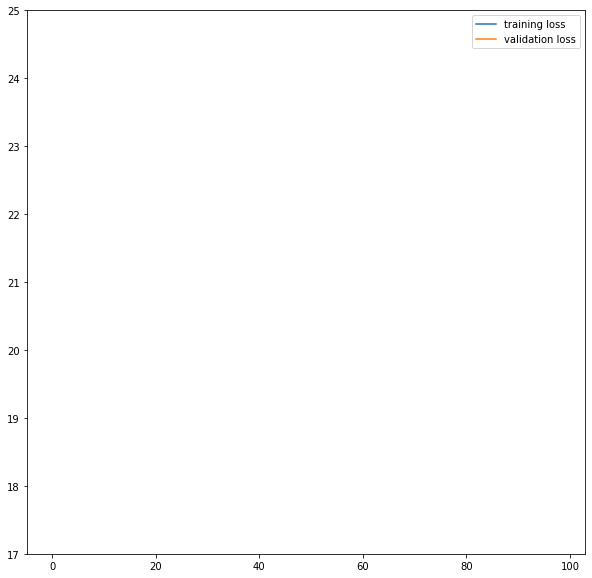

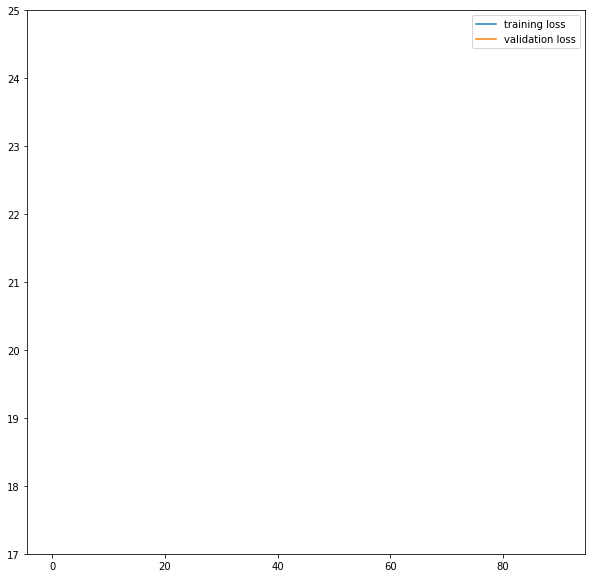

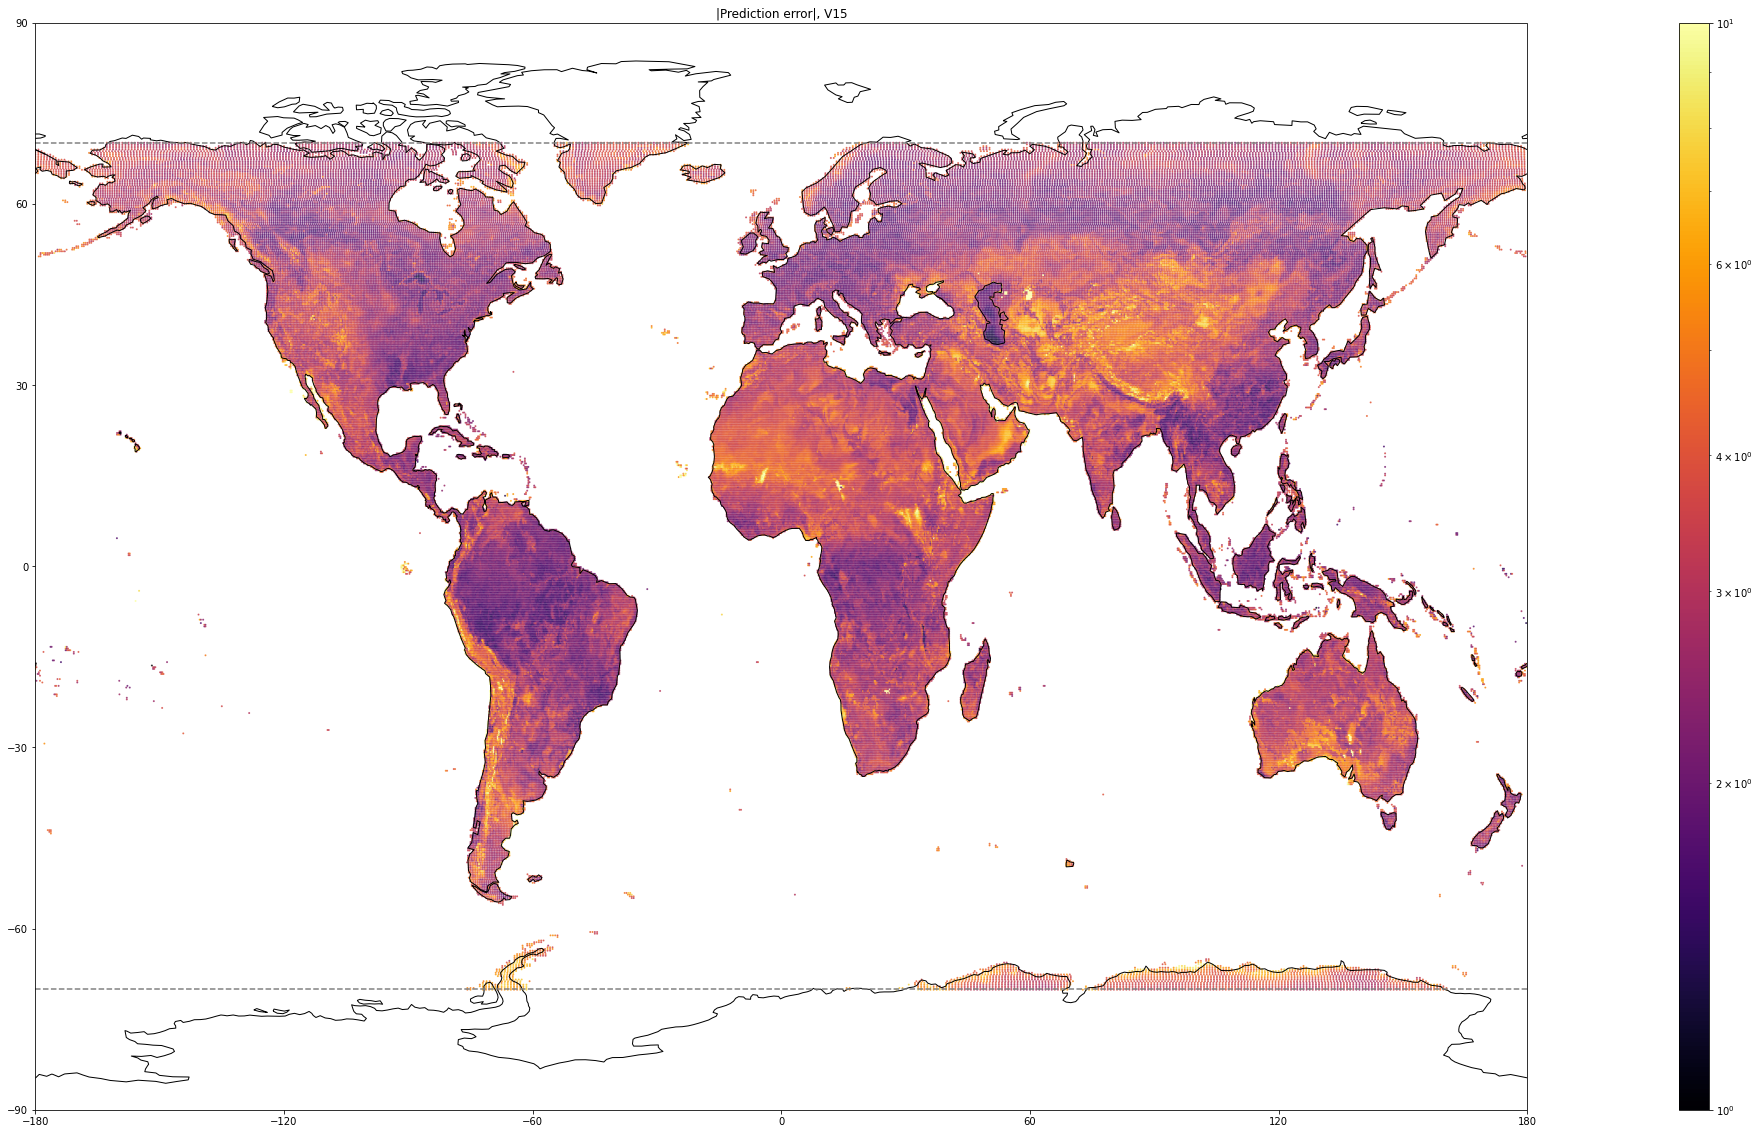

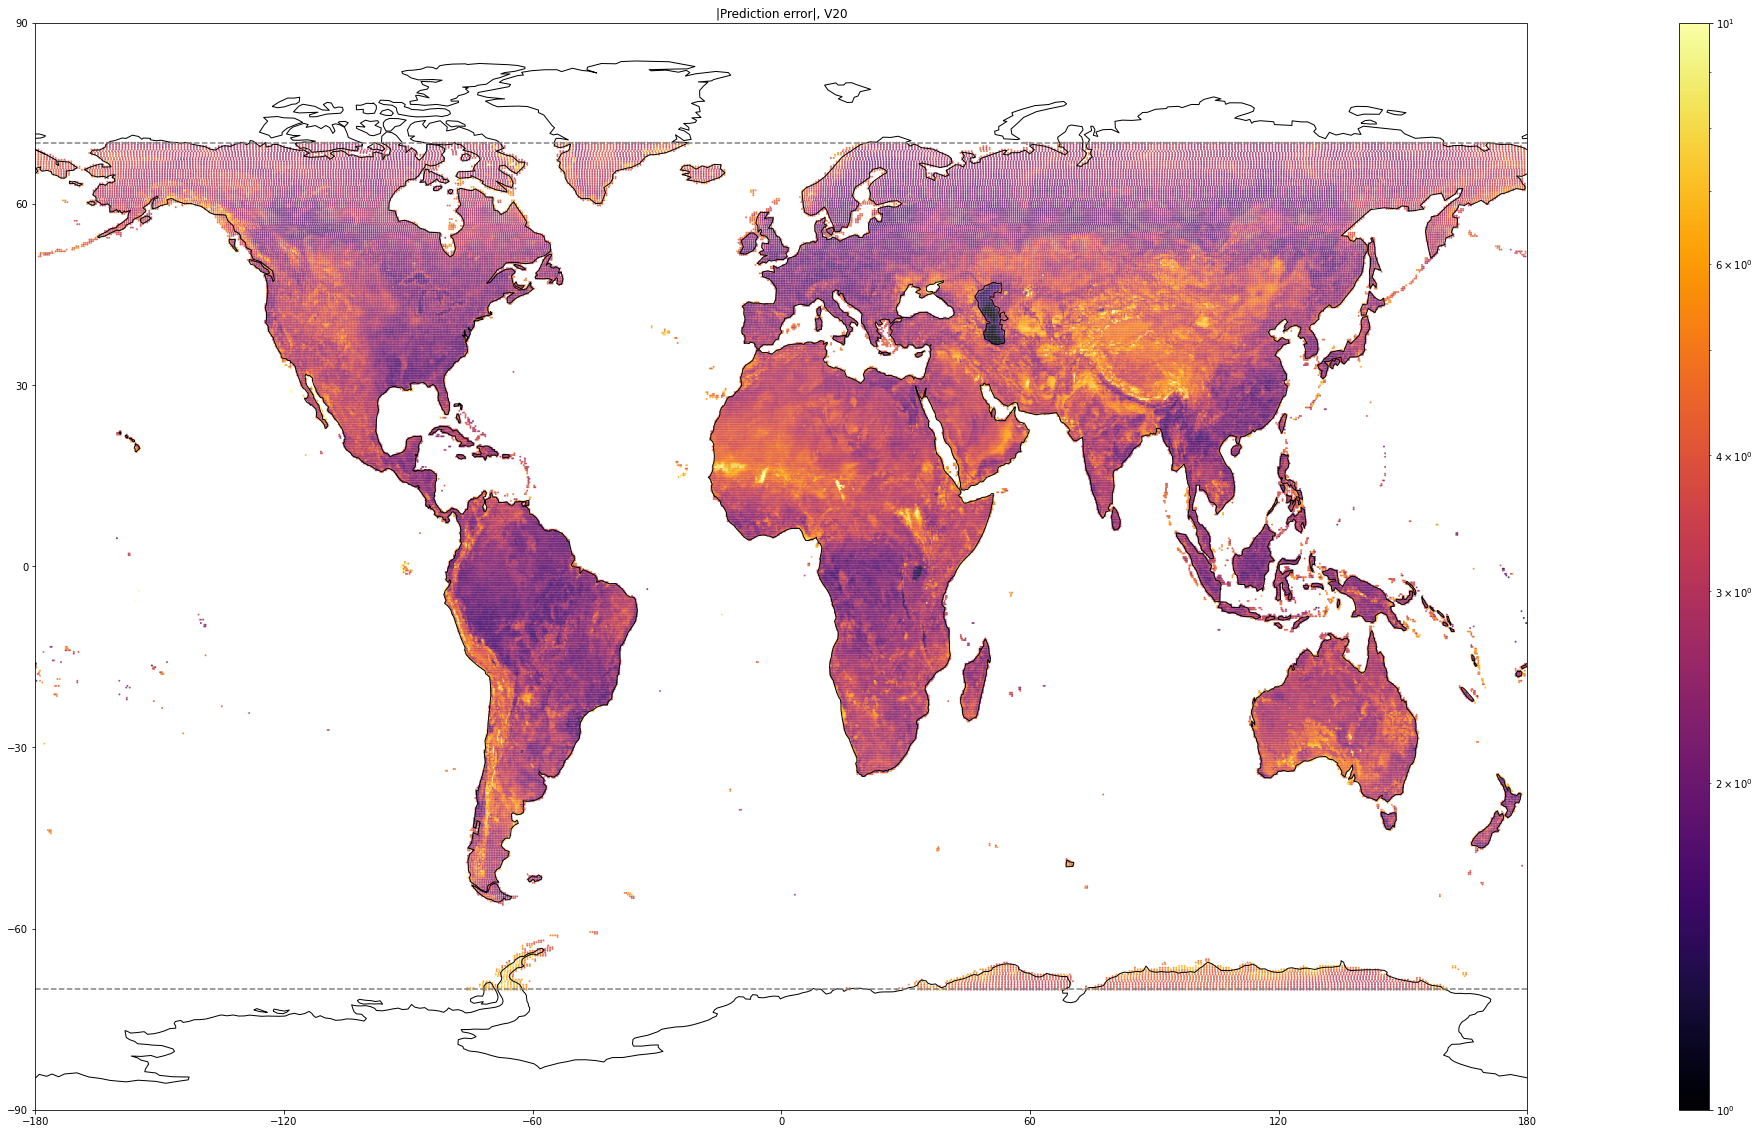

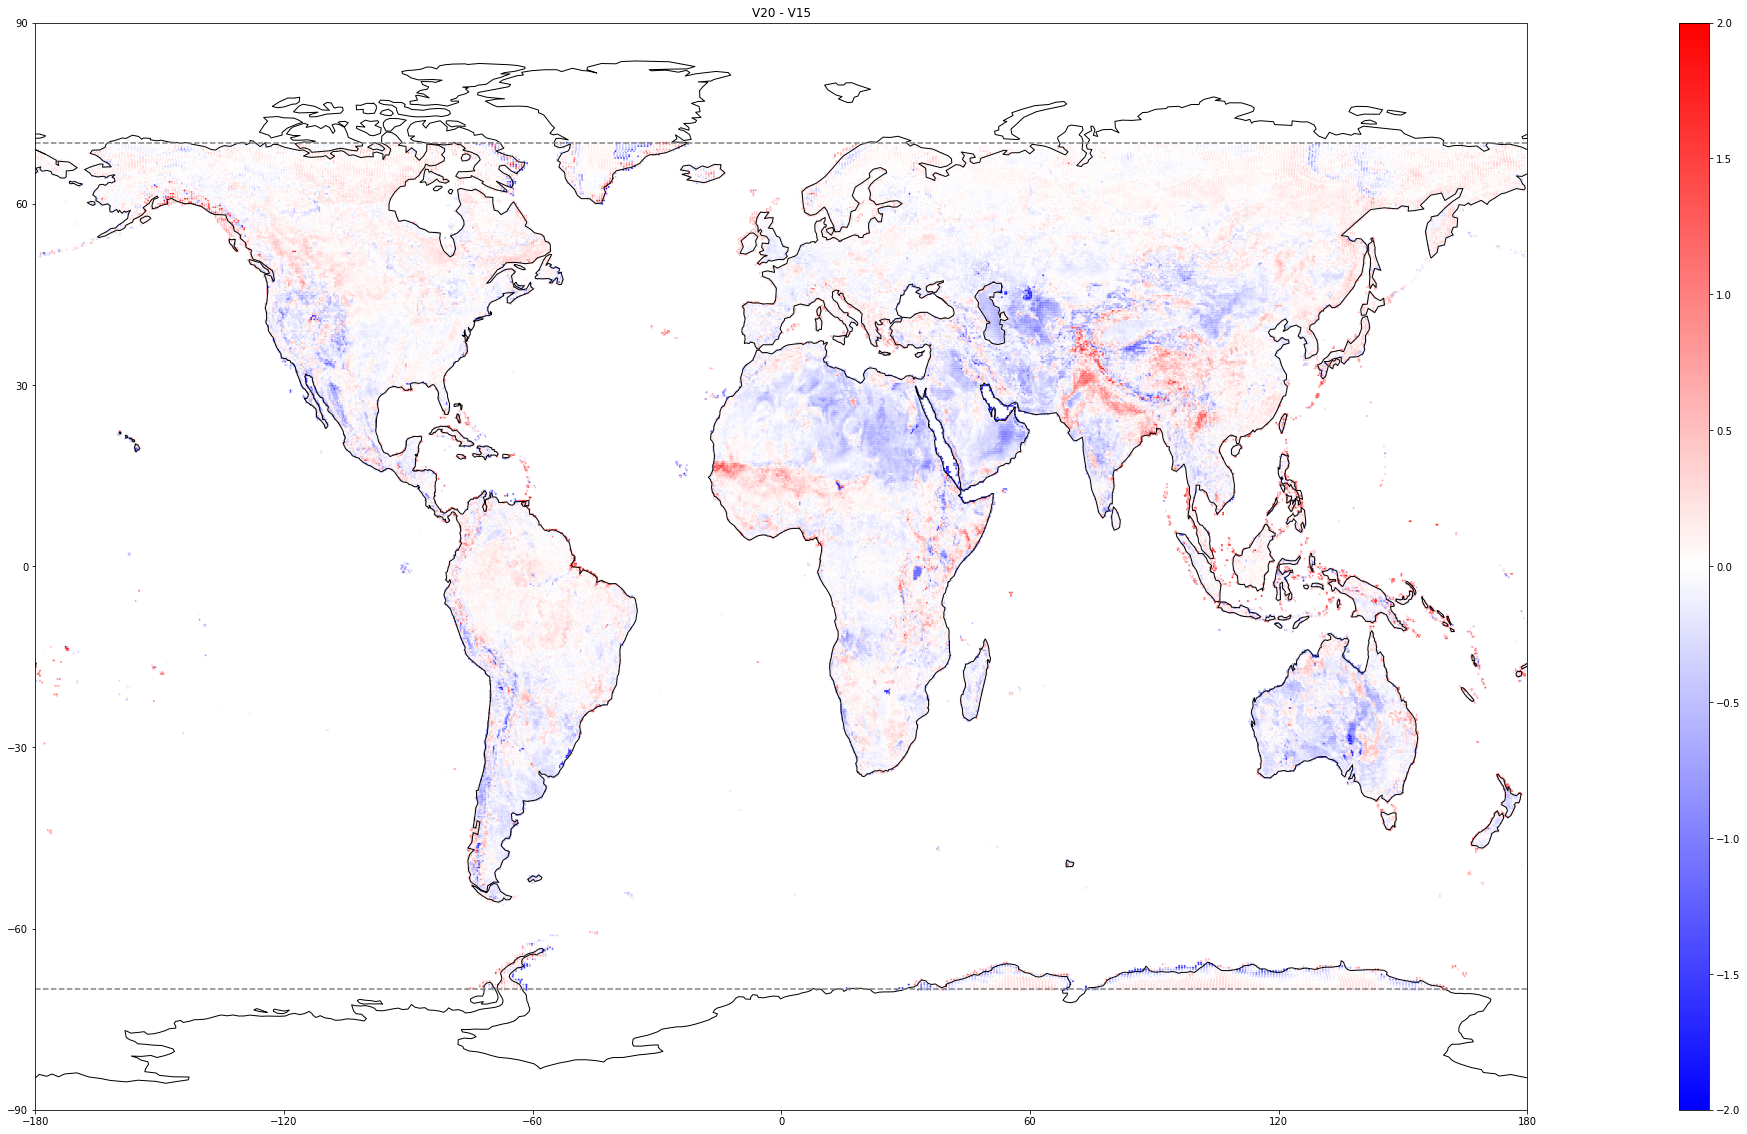

In [2]:

#Define the models to compare
models_root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/processed_data/trained_models/'
#modelV15 = models_root+'ML_5f6e838711334702b2fe6d9429c1a6ae/'#v15, batchsize 1024, LR 3e-4

modelV15 = models_root+'ML_963fe7a995c546b389402f21ef5eadd7/'#As above, with sea ice
modelV20 = models_root+'ML_1bac10ad60514426934b4709e78ddfb7/' #v20. batchsize 1024, LR 3e-4. 2 hidden layers

#new bois
#modelV15 = models_root+'ML_5454e45e659043d6b295aac93aede77e/'
#modelV20 = models_root+'ML_bb1359c84c8845e5ac22185fc3686b96/'

#modelV20 = models_root+'ML_792ce8ee7476412face8f0c36da82287/' #v20, batchsize 1024, LR 3e-4. OLD
# ML_d360eb7b7d0a4a45ad6eb421f1994552. v15, batchsize 10,000, LR 3e-4
#ML_6102888f3be74a08ba1324385b763f16 v20, batchsize 10,000, LR 3e-4

#Plotting parameters
cmap = plt.cm.inferno
logscale = True #None
vmin = 1
vmax = 10


#Process V15
V15 = load_predictions(modelV15) #Load data
V15_grouped = V15.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean() #averagee predictions over the year

#Process V20
V20 = load_predictions(modelV20)
V20_grouped = V20.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean()
    

#Plot training history, just for interest
plot_training_history(modelV15,logscale=False,jump_n_epochs=1,upper_limit = 25,lower_limit=17) 
plot_training_history(modelV20,logscale=False,jump_n_epochs=1,upper_limit = 25,lower_limit=17)
    
    
#Plot the map of the prediction error    
plot_map(V15_grouped,'absolute_model_error',vmin=vmin,vmax=vmax,cmap=cmap,logscale=logscale,title='|Prediction error|, V15',limits=None,markersize=1)
plot_map(V20_grouped,'absolute_model_error',vmin=vmin,vmax=vmax,cmap=cmap,logscale=logscale,title='|Prediction error|, V20',limits=None,markersize=1)

    
#Create a new df that will just hold the differences, and plot it    
data = {'latitude_ERA':   V20_grouped.latitude_ERA, 
        'longitude_ERA':  V20_grouped.longitude_ERA,
        'MODIS_LST':      V20_grouped.MODIS_LST,
        'V15_prediction': V15_grouped.predictions,
        'V20_prediction': V20_grouped.predictions,
        'V15_error':      V15_grouped.absolute_model_error,
        'V20_error':      V20_grouped.absolute_model_error,
        'delta':          V20_grouped.absolute_model_error - V15_grouped.absolute_model_error}
error_delta_field = pd.DataFrame(data)    
plot_map(error_delta_field,'delta',vmin=-2,vmax=+2,cmap=plt.cm.bwr,logscale=False,title='V20 - V15',limits=None,markersize=1)

---

# 2. Apply a mask


From this difference error map `V20-V15` it is hard to disentangle regions which have changed due to the improvement of the model, versus regions which have changed simply due to the inherent variability + stochasticity during training the model.

What we can do is **apply a mask to isolate just those regions where cl has been changed appreciably**. 



In [3]:
# First get the cl delta field. Go to `A1.V20_vs_V15.ipynb` to see this plotted
root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/'
version = ['v015', 'v020']
    
ds = [] #Array to hold results
for v in version:
    path = root+f'climate.{v}/climate.{v}/639l_2/clake'
    ds_i= xr.open_dataset(path,engine='cfgrib',backend_kwargs={'indexpath': ''},filter_by_keys={'shortName': 'cl'}) #only want cl 
    ds.append(ds_i)
        
#Take the difference, and make it a nice pandas df    
clake_delta_field = ds[1] - ds[0] #V20 - V15
clake_delta_field =  clake_delta_field.assign_coords({"longitude": (((clake_delta_field.longitude + 180) % 360) - 180)}) #long3 ---> long1
clake_delta_field = clake_delta_field.to_dataframe().reset_index()


In [4]:
V20_df = ds[1].to_dataframe().reset_index()
V15_df = ds[0].to_dataframe().reset_index()

clake_delta_field['V15_cl'] = V15_df.cl
clake_delta_field['V20_cl'] = V20_df.cl

conditions = [
    clake_delta_field['V15_cl'].eq(0) & clake_delta_field['V20_cl'].eq(0),
    clake_delta_field['V15_cl'].eq(0) & clake_delta_field['V20_cl'].ne(0),
    clake_delta_field['V15_cl'].ne(0) & clake_delta_field['V20_cl'].eq(0),
    clake_delta_field['V15_cl'].ne(0) & clake_delta_field['V20_cl'].ne(0),
]



choices = ["Was not lake, Is not Lake",
           "Was not lake, Is Lake",
           "Was lake, Is Not Lake",
           "Was lake, Is Lake",
          ]

clake_delta_field['classification'] = np.select(conditions, choices,default='other')

counts_table = clake_delta_field.groupby('classification').count()
counts_table['counts'] = counts_table['cl'] #create a new column which we will surface
display(counts_table[['counts']])


counts
classification                   
Was lake, Is Lake           70442
Was lake, Is Not Lake        4393
Was not lake, Is Lake       33847
Was not lake, Is not Lake  433398

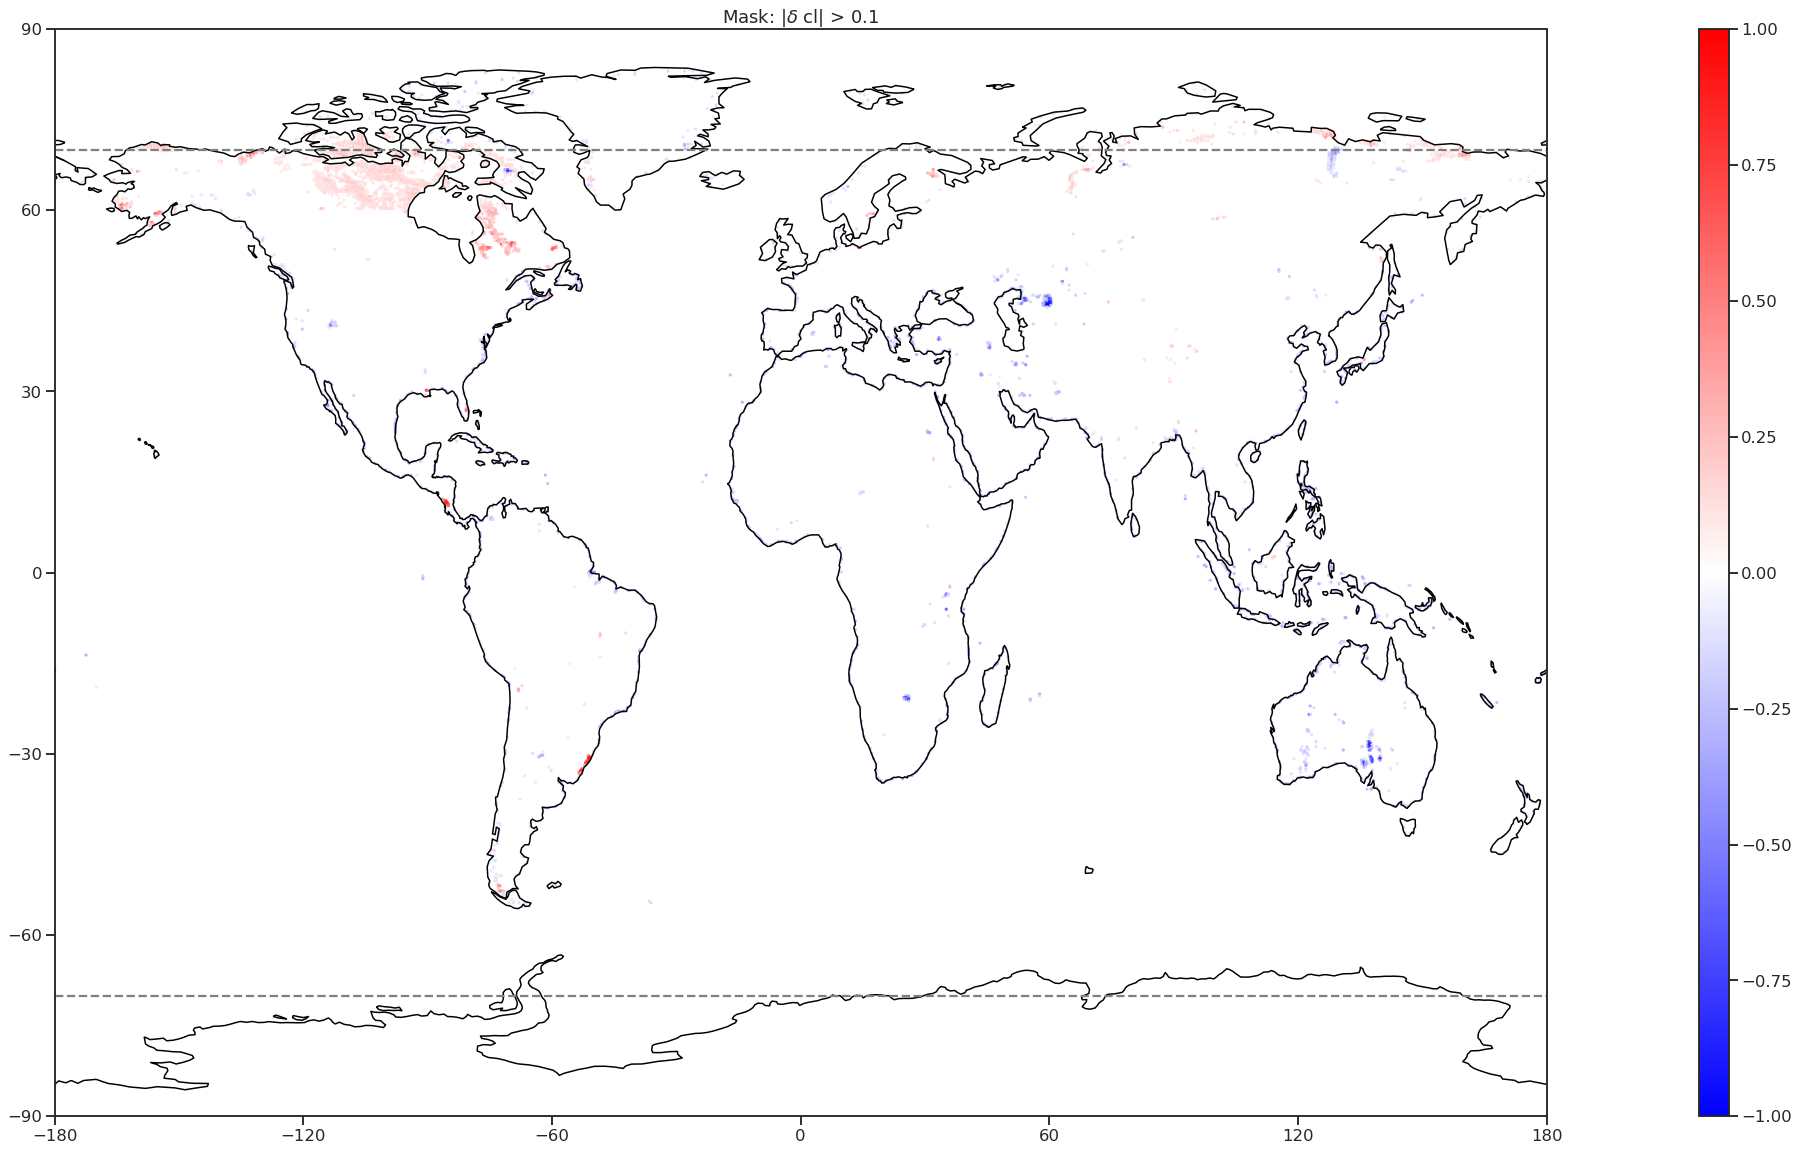

In [12]:
#Use cl delta field to create a mask 
p = 0.1 # cutoff paramter. Only get points with change in lake cover > p
mask = clake_delta_field.query(f'abs(cl) > {p}')

#Plot the mask
plot_map(mask,'cl',vmin=-1,vmax=1,cmap=plt.cm.bwr,logscale=False,title=f'Mask: |${{\delta}}$ cl| > {p}',limits=None,markersize=5) #What does this mask look like?

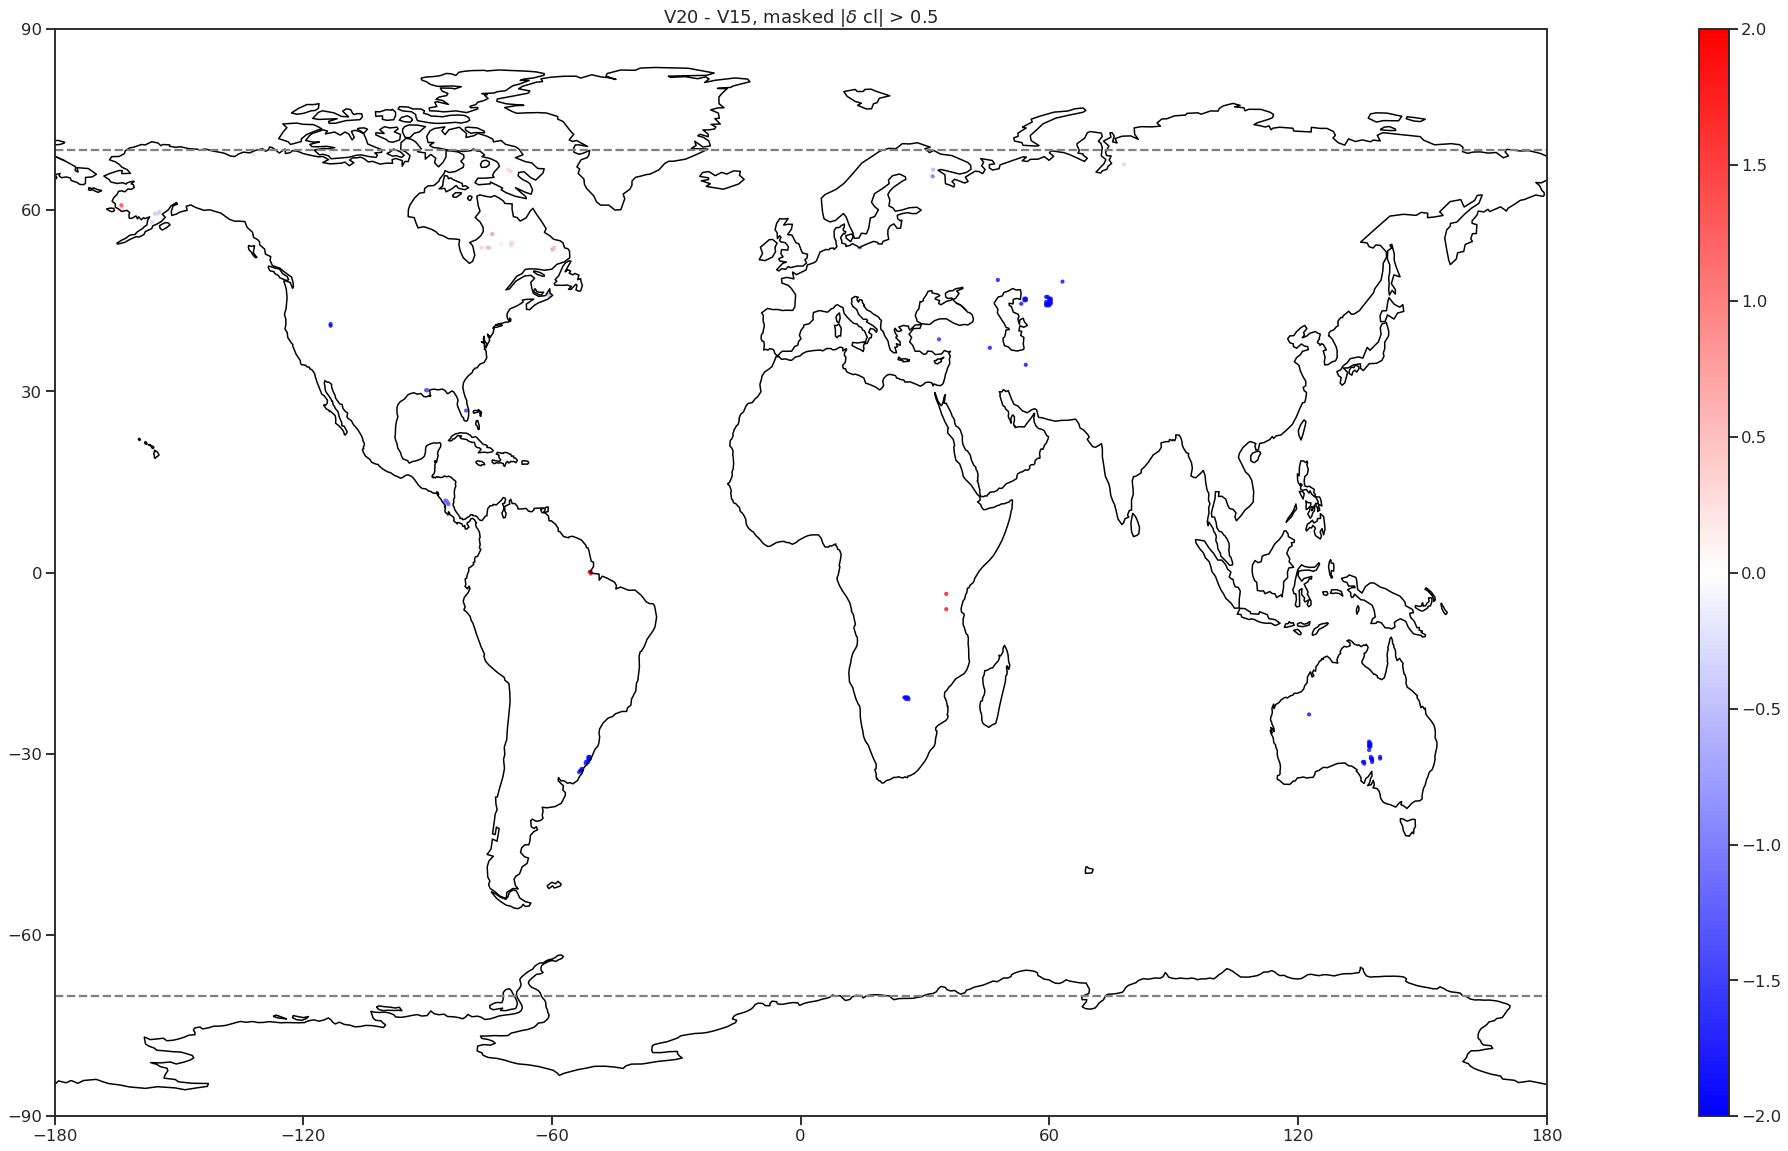

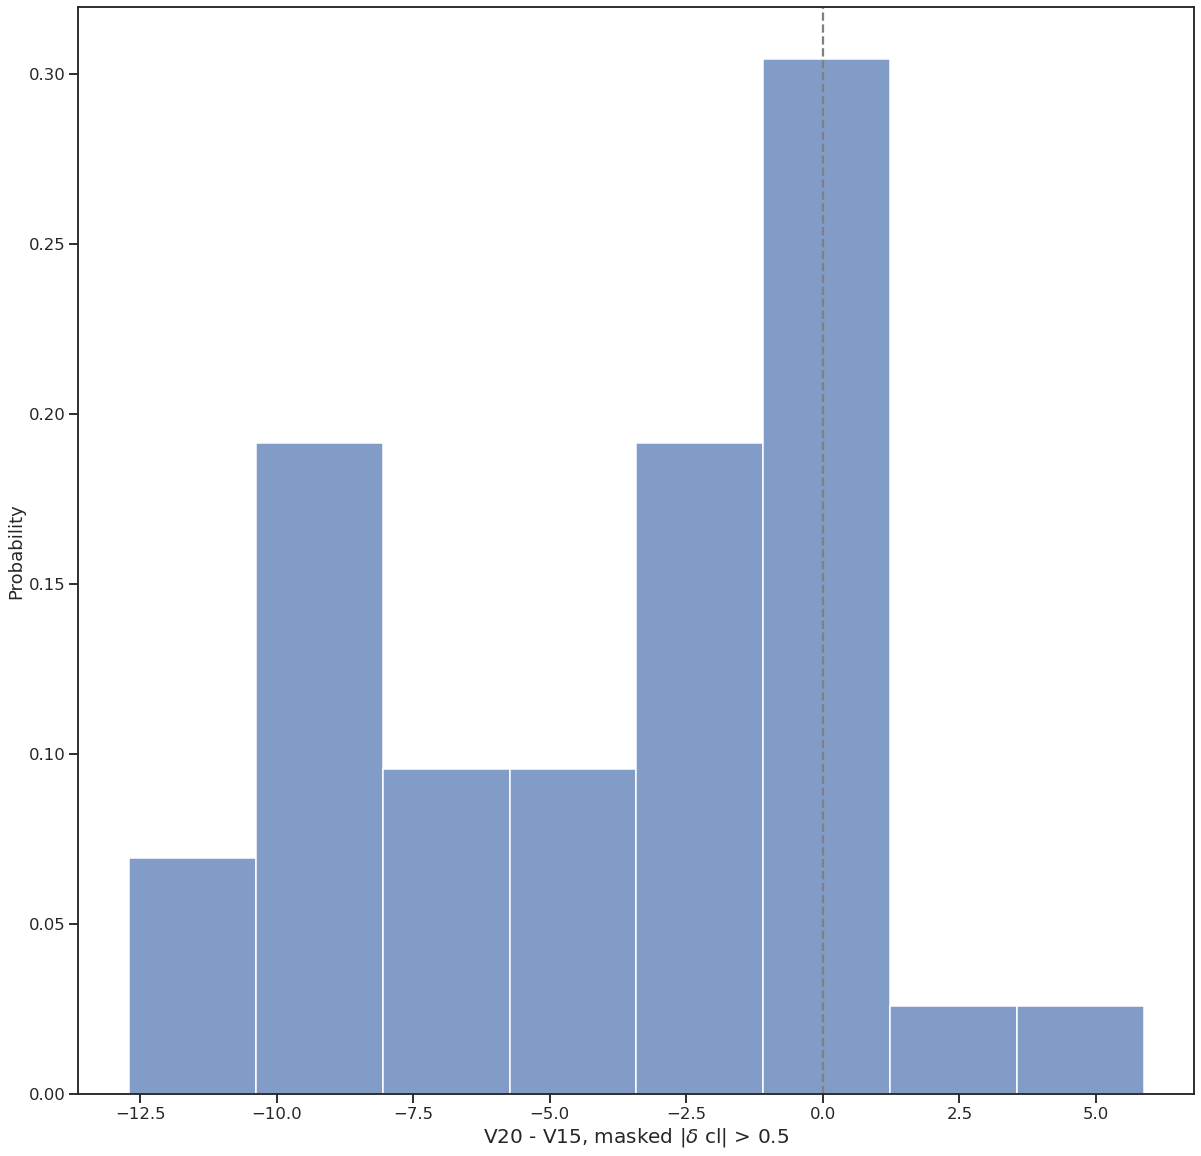

Mean change in model error = -3.8856688
Number of samples with |p| > 0.5 is: 115
Greatest improvement:


latitude_ERA  longitude_ERA  MODIS_LST  V15_prediction  V20_prediction  \
30     -28.24355       137.1875   315.2164      295.050568      307.929535   

    V15_error  V20_error      delta  values   step  surface  latitude  \
30  20.165833   7.466327 -12.699506  397456 0 days      0.0 -28.24355   

    longitude        cl    V15_cl  V20_cl         classification  
30   137.1875 -0.998833  0.998833     0.0  Was lake, Is Not Lake

Worst improvement: 


latitude_ERA  longitude_ERA   MODIS_LST  V15_prediction  V20_prediction  \
40     -6.042153       35.15625  305.171234      301.793335      314.577148   

    V15_error  V20_error     delta  values   step  surface  latitude  \
40   3.531063   9.405912  5.874849  298045 0 days      0.0 -6.042153   

    longitude        cl    V15_cl    V20_cl     classification  
40   35.15625 -0.727888  0.752164  0.024276  Was lake, Is Lake

Groupby classification 


latitude_ERA  longitude_ERA   MODIS_LST  V15_prediction  V20_prediction  \
40     -6.042153       35.15625  305.171234      301.793335      314.577148   

    V15_error  V20_error     delta  values   step  surface  latitude  \
40   3.531063   9.405912  5.874849  298045 0 days      0.0 -6.042153   

    longitude        cl    V15_cl    V20_cl     classification  
40   35.15625 -0.727888  0.752164  0.024276  Was lake, Is Lake

In [11]:
#Apply the mask to the global error_delta_field from section 1
masked_error_delta_field = pd.merge(error_delta_field,mask,how='inner',left_on=['latitude_ERA', 'longitude_ERA'], right_on=['latitude', 'longitude']) #inner join.


# Plot it, along with a distribution of the errors
plot_map(masked_error_delta_field,
         'delta',
         vmin=-2,vmax=+2,
         cmap=plt.cm.bwr,
         logscale=False,
         title=f'V20 - V15, masked |${{\delta}}$ cl| > {p}',
         limits=None,
         markersize=10)
    
plot_distribution(masked_error_delta_field,
                  'delta',
                  bins='auto',
                  xlabel = f'V20 - V15, masked |${{\delta}}$ cl| > {p}')





#Surface some numbers
print('Mean change in model error =', masked_error_delta_field.delta.mean())
print (f'Number of samples with |p| > {p} is:',  len(masked_error_delta_field))
print ('Greatest improvement:')
display(masked_error_delta_field[masked_error_delta_field.delta == masked_error_delta_field.delta.min()])  #small numbers show V20 > V15
print ('Worst improvement: ') 
display(masked_error_delta_field[masked_error_delta_field.delta == masked_error_delta_field.delta.max()])  #Large numbers show V20 < V15
print ('Groupby classification ') 
display(masked_error_delta_field[masked_error_delta_field.delta == masked_error_delta_field.delta.max()])  #Large numbers show V20 < V15

In [7]:
grouped = masked_error_delta_field.groupby('classification').agg(count=('delta', 'size'), AverageErrorChange=('delta', 'mean'))#.reset_index()

In [8]:
grouped

count  AverageErrorChange
classification                                  
Was lake, Is Lake       3570           -0.146425
Was lake, Is Not Lake    333           -1.045553
Was not lake, Is Lake    411            0.010487

---

# 3. Analysis

In [9]:
display(masked_error_delta_field.sort_values(by=['delta'],ascending=False).head(20))

latitude_ERA  longitude_ERA   MODIS_LST  V15_prediction  V20_prediction  \
792      -6.042153      35.156250  305.171234      301.793335      314.577148   
865      -3.512879      35.156250  301.797272      299.813934      309.993744   
1375     13.067912      14.343750  300.484894      302.224792      307.229340   
1015     -0.140515     -50.625000  300.542664      302.529663      306.432251   
1023      0.140515     -50.625000  299.526062      302.133148      305.706757   
691      -8.852456      29.531250  303.929596      302.827423      309.104034   
1022      0.140515     -50.906250  301.339539      302.253937      306.484497   
608     -13.629972    -172.406250  297.642883      297.452728      302.604462   
2981     59.999970    -139.733333  267.747040      268.290558      273.471466   
915      -2.388758     -43.312500  303.572052      304.982849      308.252319   
1124      4.355971       6.187500  299.952911      306.375641      308.947144   
4249     69.836018     -69.750000  257.133789      254.528992      251.423721   
1025      0.140515     -49.781250  301.715790      302.355072      306.036316   
1658     21.779853      88.888889  300.232300      304.381653      306.782593   
1675     22.060883      89.481481  299.507874      302.936310      305.333618   
1098      2.669788     114.468750  299.783203      299.774292      296.063507   
3087     61.124090    -146.812500  269.018280      270.645142      274.467651   
2914     58.594819    -136.500000  270.431366      272.117981      276.336121   
1539     18.407488     -72.843750  303.084442      304.716522      307.902039   
4299     70.117048     -27.750000  261.755768      260.319489      256.339020   

      V15_error  V20_error     delta  values   step  surface   latitude  \
792    3.531063   9.405912  5.874849  298045 0 days      0.0  -6.042153   
865    2.596229   8.248317  5.652088  286525 0 days      0.0  -3.512879   
1375   2.316374   6.791271  4.474896  210931 0 days      0.0  13.067912   
1015   2.272953   5.889603  3.616650  272140 0 days      0.0  -0.140515   
1023   2.792777   6.180697  3.387920  270860 0 days      0.0   0.140515   
691    2.419416   5.310309  2.890893  310825 0 days      0.0  -8.852456   
1022   2.276047   5.147219  2.871172  270859 0 days      0.0   0.140515   
608    2.273959   5.049660  2.775701  333147 0 days      0.0 -13.629972   
2981   4.484399   7.059263  2.574864   37432 0 days      0.0  59.999970   
915    2.139337   4.695339  2.556002  282406 0 days      0.0  -2.388758   
1124   6.440516   8.994224  2.553707  250582 0 days      0.0   4.355971   
4249   3.958959   6.441704  2.482745   17469 0 days      0.0  69.836018   
1025   1.860479   4.333038  2.472560  270863 0 days      0.0   0.140515   
1658   4.150498   6.550280  2.399781  171760 0 days      0.0  21.779853   
1675   3.433743   5.825744  2.392001  170547 0 days      0.0  22.060883   
1098   1.521555   3.885339  2.363784  258647 0 days      0.0   2.669788   
3087   4.818341   7.144187  2.325847   34787 0 days      0.0  61.124090   
2914   4.059495   6.336097  2.276602   40931 0 days      0.0  58.594819   
1539   2.618852   4.886765  2.267914  187581 0 days      0.0  18.407488   
4299   4.132009   6.393384  2.261375   17045 0 days      0.0  70.117048   

       longitude        cl    V15_cl    V20_cl         classification  
792    35.156250 -0.727888  0.752164  0.024276      Was lake, Is Lake  
865    35.156250 -0.638541  0.640495  0.001954      Was lake, Is Lake  
1375   14.343750 -0.163499  0.634733  0.471234      Was lake, Is Lake  
1015  -50.625000 -0.588097  0.598120  0.010022      Was lake, Is Lake  
1023  -50.625000 -0.603153  0.611717  0.008564      Was lake, Is Lake  
691    29.531250 -0.183428  0.528210  0.344782      Was lake, Is Lake  
1022  -50.906250 -0.604843  0.607917  0.003075      Was lake, Is Lake  
608  -172.406250 -0.378005  0.378016  0.000011      Was lake, Is Lake  
2981 -139.733333 -0.172293  0.183239  0.010946      Was lake, Is Lake  
915   -4

# Appendix

Old material

In [ ]:






#Get a map of the original V15 lsm. This will only be used to get rid of oceans
root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/'
lsm_path = root+f'climate.v015/climate.v015/639l_2/lsmoro'
ds_lsm= xr.open_dataset(lsm_path,engine='cfgrib',backend_kwargs={'indexpath': ''},filter_by_keys={'shortName': 'lsm'}) 
ds_lsm = correct_longitude(ds_lsm)
lsm_df = ds_lsm.to_dataframe().reset_index() #Make it a df
all_fields = lsm_df.copy()



#Now look at all the features which are changing
changing_features = ['cl','lsm','dl','cvl','cvh','anor','isor','slor','sr','lsrh']
changing_files =    ['clake','lsmoro','lakedl','sfc','sfc','sfc','sfc','sfc','sfc','sfc']


for i in range(len(changing_features)): 
    file = changing_files[i]
    feature=changing_features[i]
    delta = difference_in_surface_fields(file,feature)
    
    all_fields[f'delta_{feature}'] = delta[feature].values
    
    
    
    
print ('Plotting map of changing features')
for f in changing_features: 
    plot_map(all_fields,f'delta_{feature}',vmin=1e-2,vmax=10,cmap=plt.cm.bwr,logscale=True,title=f'Change in {feature}',limits=limits,markersize=1)
    
    
# #We can define some masks based on how we want to filter the data
# strong_mask = all_fields.query('abs(delta_cl) > 0.1 & abs(delta_lsm) > 0.0 & abs(delta_dl)>0.0 & abs(delta_cvl) > 0.0 & abs(delta_cvh) > 0.0')
# weak_mask = all_fields.query('abs(delta_cl) > 0.1')

# plot_map(all_fields,'delta_cl',vmin=-0.05,vmax=+0.01,cmap=plt.cm.bwr,logscale=False,title='Change in lake cover',limits=limits,markersize=1)
# plot_map(strong_mask,'delta_cl',vmin=1e-1,vmax=+1,cmap=plt.cm.bwr,logscale=True,title=f'Strong Mask: Change in Lake cover cl',limits=None,markersize=10) #What does this mask look like?
# plot_map(weak_mask,'delta_cl',vmin=1e-1,vmax=+1,cmap=plt.cm.bwr,logscale=True,title=f'Weak Mask, Change in Lake cover cl',limits=None,markersize=10) #What does this mask look like?





# #Now look at all the features which are changing
# changing_features = ['cl','lsm','dl','cvl','cvh','anor','isor','slor','sr','lsrh']
# changing_files =    ['clake','lsmoro','lakedl','sfc','sfc','sfc','sfc','sfc','sfc','sfc']


# for i in range(len(changing_features)): 
#     file = changing_files[i]
#     feature=changing_features[i]
#     delta = difference_in_surface_fields(file,feature)
    
#     all_fields[f'delta_{feature}'] = delta[feature].values
    
    
    
    
# print ('Plotting map of changing features')
# for f in changing_features: 
#     plot_map(all_fields,f'delta_{feature}',vmin=1e-2,vmax=10,cmap=plt.cm.bwr,logscale=True,title=f'Change in {feature}',limits=limits,markersize=1)

    

In [ ]:
# from matplotlib.gridspec import GridSpec
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import xarray as xr
# import matplotlib.colors as mc
# import matplotlib.colorbar as cb 




# def correct_longitude(ds):    
#     return ds.assign_coords({"longitude": (((ds.longitude + 180) % 360) - 180)})


# def plot_map(ds,z,vmin,vmax,cmap,logscale,title,limits,markersize):
    
#     """Scatter plot. Bit hacky. """

#     try:
#         x = ds.longitude
#         y = ds.latitude
#     except: #different sources call lat/lon different things
#         x = ds.longitude_ERA
#         y = ds.latitude_ERA
    
#     z1 = ds[z]
    

    
#     #Setup figure and axes
#     fig = plt.figure(figsize=[30,20])
#     gs = GridSpec(1, 2, figure=fig, width_ratios=[50,1])
#     ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree(central_longitude=0))
#     cax = fig.add_subplot(gs[1])
    
#     #Cmaps, normalisations
#     if logscale:
#         norm = mc.LogNorm(vmin=vmin, vmax=vmax)
#         z1 = abs(z1)
#     else:
#         norm = mc.Normalize(vmin=vmin, vmax=vmax)

    
#     cb1 = cb.ColorbarBase(cax, cmap=cmap,
#                                 norm=norm,
#                                 orientation='vertical')
    
    
    
#     #Plot it
#     sc=ax.scatter(x,y,s=markersize,c=cmap(norm(z1)),
#                 linewidths=1, alpha=.7)

    
#     #Tidy up
#     ax.axhline(70, c='0.5', linestyle='--')
#     ax.axhline(-70, c='0.5', linestyle='--') #latitude cutoffs

#     ax.set_title(title)    
#     ax.coastlines()

    
#     ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
#     ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
#     ax.set_aspect('auto') #Force projection aspect ratio
    
#     if limits is not None:
#         ax.set_xlim(limits['xlow'],limits['xhigh'])
#         ax.set_ylim(limits['ylow'],limits['yhigh'])
#         ax.set_xticks([])
#         ax.set_yticks([])

#     plt.show()
    
    
    
    
# def difference_in_surface_fields(file,feature):
    
    
#     version = ['v015', 'v020']
    
#     ds = [] #Array to hold results
#     for v in version:
#         path = root+f'climate.{v}/climate.{v}/639l_2/{file}'
#         ds_i= xr.open_dataset(path,engine='cfgrib',backend_kwargs={'indexpath': ''},filter_by_keys={'shortName': feature}) 
#         ds.append(ds_i)
        
        
    
#     #Take the difference    
#     delta = ds[1] - ds[0] #V20 - V15
#     delta = correct_longitude(delta) #long3 ---> long1
    
#     return delta
    